# 10.1 Nienadzorowana reprezentacja danych

W tym skrypcie znajdziemy wyniki eksperymentów opisanych w rozdziale 10.1 ,,Nienadzorowana reprezentacja danych'', które dotyczą modeli autoenkoderowych tj. AutoEnkoder (AE), Variational AutoEncoder (VAE) i Wasserstein AutoEncoder (WAE).


### Importowanie niezbędnych modułow

In [1]:
import pickle
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm


print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)

PyTorch: 1.10.0
Torchvision: 0.11.1


Klasa ,,*AverageMeter*'' przechowuje oraz przetwarza częściowe wyniki zapisywane w poszczegółnych etapach uczenia modelu. Funkcja ,,*count_parameters*'' zlicza liczbę parametrów sieci, zaś funkcja ,,*show*'' rysuje obrazki ze zbioru danych i ich rekonstrukcje.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=2.5)
sns.set_style("whitegrid")


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum = self.sum + val * n
        self.count = self.count + n
        self.avg = self.sum / self.count


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def show(img, recon_img, num_col=None):
    if recon_img is None:
        rec_images = img
    else:
        n = img.shape[0]
        assert n >= num_col
        rec_images = torch.empty((2 * num_col, *img.shape[1:]))
        rec_images.data[:num_col] = img.data[:num_col]
        rec_images.data[num_col:] = recon_img.data[:num_col]

    plt.figure(figsize=[16, 8])
    grid = torchvision.utils.make_grid(
        rec_images, nrow=num_col, padding=1, normalize=True, scale_each=True
    )
    np_grid = grid.cpu().numpy()
    plt.axis("off")
    plt.imshow(np.transpose(np_grid, (1, 2, 0)), interpolation="nearest")

# Dataloader

W tej części przygotowujemy zbiór danych do trenowania i walidacji modelu. Przetwarzamy obrazki ze zbioru *MNIST* do tensorów, które są pobierane iteracyjnie w batchach podczas trenowania sieci (zmienne: ,,*train_loader*'', ,,*test_loader*'').

In [3]:
root = "/datasets"
download = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root, download=download, train=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False
)

test_dataset = torchvision.datasets.MNIST(
    root, download=download, train=False, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=200, shuffle=False, num_workers=4, pin_memory=False
)

device=device(type='cuda')


Poniżej tworzymy dodatkowe klasy, których będziemy używać do budowy sieci neuronowej (klasa ,,*View*'') jak również do uczenia jej (klasa ,,*LambdaLR*''). 

In [4]:
class View(torch.nn.Module):
    def __init__(self, *shape) -> None:
        super(View, self).__init__()
        self.shape = shape

    def forward(self, input_x: torch.Tensor) -> torch.Tensor:
        return input_x.view(*self.shape)


class LambdaLR(torch.optim.lr_scheduler.LambdaLR):
    def __init__(
        self, optimizer, lr_lambda, last_epoch=-1, verbose=False, min_val=1e-5
    ):
        self.min_val = min_val
        self.change = True

        super(LambdaLR, self).__init__(optimizer, lr_lambda, last_epoch, verbose)

    def step(self, epoch=None):
        if self.change:
            super().step(epoch)

            change = False
            values = self.get_last_lr()
            for i, data in enumerate(zip(self.optimizer.param_groups, values)):
                param_group, lr = data
                param_group["lr"] = lr if lr > self.min_val else self.min_val
                self.print_lr(self.verbose, i, lr, epoch)

            self._last_lr = [group["lr"] for group in self.optimizer.param_groups]

# AutoEncoder

Klasa ,,*AE*'' definuje sieć autoenkodera składająca się z dwóch części: kodującej (enkodera) i dekodującej (dekodera). Sieć bazuje na warstwach konwolucyjnych. 

In [5]:
from typing import Tuple


class AE(torch.nn.Module):
    def __init__(self, latent_dim: int, dim_hidden: int) -> None:
        super(AE, self).__init__()

        self.latent_dim = latent_dim
        self.dim_h = dim_hidden

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, self.dim_h, 4, 2, 1, bias=False),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(self.dim_h * 2),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(self.dim_h * 4),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(self.dim_h * 8),
            torch.nn.ReLU(True),
            torch.nn.Flatten(),
            torch.nn.Linear(self.dim_h * (2**3), latent_dim),
        )

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, self.dim_h * 8 * 7 * 7),
            torch.nn.ReLU(True),
            View(-1, self.dim_h * 8, 7, 7),
            torch.nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            torch.nn.BatchNorm2d(self.dim_h * 4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            torch.nn.BatchNorm2d(self.dim_h * 2),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            torch.nn.Sigmoid(),
        )

    def forward(self, input_x: torch.Tensor) -> Tuple[torch.Tensor]:
        z = self.encoder(input_x)
        return z, self.decoder(z)

Uczenie modelu i jego walidacja.

In [ ]:
latent_dim = 8
dim_hidden = 16

model = AE(latent_dim=latent_dim, dim_hidden=dim_hidden)
model = model.to(device)
print(model)
print(f"Number of parameters: {count_parameters(model)}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

use_scheduler = True
scheduler = None
if use_scheduler:
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.8**epoch, min_val=1e-5)

mse_loss = torch.nn.MSELoss()

scores = {"train": {"loss": []}, "test": {"loss": []}}

epochs = 25
for epoch in range(epochs):

    # training
    model.train()

    losses = AverageMeter()

    train_tqdm = tqdm(train_loader, total=len(train_loader), leave=False)
    for image, _ in train_tqdm:
        image = image.to(device)

        _, recon = model(image)
        loss = mse_loss(recon, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.update(loss.item())

        train_tqdm.set_description(f"TRAIN loss: {losses.val:.4g} ({losses.avg:.4g})")

    scores["train"]["loss"].append(losses.avg)
    if use_scheduler:
        scheduler.step()

    # validating
    model.eval()

    losses = AverageMeter()

    with torch.no_grad():
        eval_tqdm = tqdm(test_loader, total=len(test_loader), leave=False)
        for image, _ in eval_tqdm:
            image = image.to(device)

            _, recon = model(image)
            loss = mse_loss(recon, image)

            losses.update(loss.item())

            eval_tqdm.set_description(f"TEST loss: {losses.val:.4g} ({losses.avg:.4g})")

    scores["test"]["loss"].append(losses.avg)

    print(
        f"Epoch: [{epoch + 1}/{epochs}]; "
        f"train: {scores['train']['loss'][-1]:.4g}; "
        f"test: {scores['test']['loss'][-1]:.4f}"
        f"{f'; lr: {scheduler.get_last_lr()[0]:.4g}' if use_scheduler else ''}"
    )

torch.save(
    model.state_dict(), "ae.pth"
)  # zapisujemy model do dalszej ewaluacji np. obliczenia FID score

Poniżej przedstawiamy zmianę funkcji kosztu sieci AE w trakcie jej uczenia.

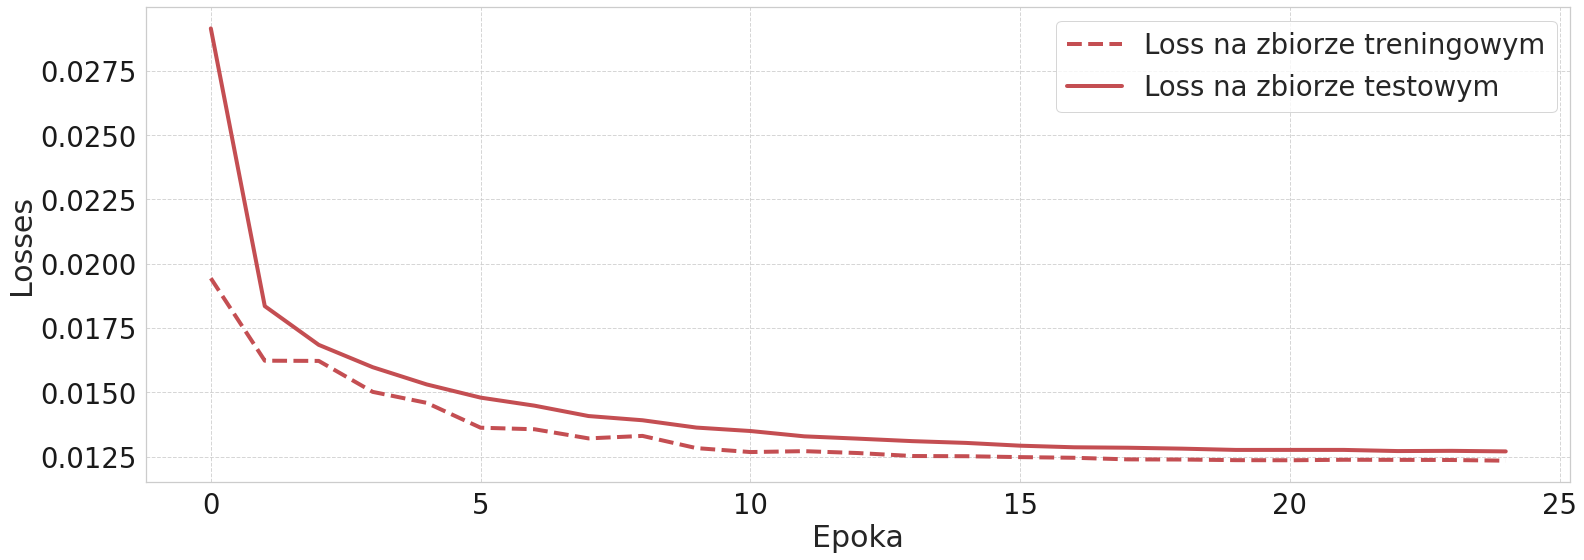

In [8]:
# loss
fig = plt.figure(figsize=(22, 8))
ax = fig.add_subplot(111)
ax.plot(
    scores["test"]["loss"],
    "r--",
    linewidth=4,
    markersize=12,
    label="Loss na zbiorze treningowym",
)
ax.plot(
    scores["train"]["loss"],
    "r-",
    linewidth=4,
    markersize=12,
    label="Loss na zbiorze testowym",
)
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.legend(loc=0)
ax.set_ylabel("Losses")
ax.set_xlabel("Epoka")
plt.tight_layout(pad=0.5)

plt.show()
plt.close()

Czas teraz na pokazanie jak wyuczona sieć AE rekonstruuje obrazki ze zbioru MNIST. W tym celu przepuszczamy przez sieć obrazki ze zbioru walidującego (górny wiersz obrazka), a sieć zwraca ich rekonstrukcje (dolny wiersz obrazka).  

  0%|          | 0/50 [00:00<?, ?it/s]

Ewaluation MSE: 0.01234


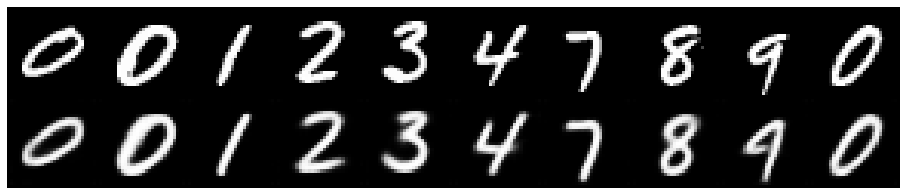

In [15]:
# validating
model.eval()

mses = AverageMeter()

with torch.no_grad():
    eval_tqdm = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
    for i, (image, _) in eval_tqdm:
        image = image.to(device)

        _, recon = model(image)
        loss = mse_loss(recon, image)

        mses.update(loss.item())

        eval_tqdm.set_description(f"mse: {mses.val:.4g} ({mses.avg:.4g})")

        if i == len(test_loader) - 1:
            show(image, recon, 10)

print(f"Ewaluation MSE: {mses.avg:.4g}")

# Variational AutoEncoder

Klasa ,,*VAE*'' definuje sieć variational autoenkodera składająca się podobnie jak w sieci AE z dwóch części: kodującej (enkodera) i dekodującej (dekodera). Sieć bazuje na warstwach konwolucyjnych. Model VAE jest przykładowym modelem generatywnym, których sample (losowe obrazki) pochodzą z rozkładu gaussowskiego $\mathcal{N}(0, 1)$.

In [16]:
from typing import Tuple


class VAE(torch.nn.Module):
    def __init__(self, latent_dim: int, dim_hidden: int) -> None:
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.dim_h = dim_hidden

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, self.dim_h, 4, 2, 1, bias=False),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(self.dim_h * 2),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(self.dim_h * 4),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(self.dim_h * 8),
            torch.nn.ReLU(True),
            torch.nn.Flatten(),
        )

        # Latent
        self.mu = torch.nn.Linear(self.dim_h * (2**3), latent_dim)
        self.logvar = torch.nn.Linear(self.dim_h * (2**3), latent_dim)

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, self.dim_h * 8 * 7 * 7),
            torch.nn.ReLU(True),
            View(-1, self.dim_h * 8, 7, 7),
            torch.nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            torch.nn.BatchNorm2d(self.dim_h * 4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            torch.nn.BatchNorm2d(self.dim_h * 2),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            torch.nn.Sigmoid(),
        )

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input_x: torch.Tensor) -> Tuple[torch.Tensor]:
        x = self.encoder(input_x)

        mu = self.mu(x)
        log_var = self.logvar(x)

        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

    def criterion(
        self,
        recon_x: torch.Tensor,
        x: torch.Tensor,
        mu: torch.Tensor,
        log_var: torch.Tensor,
        kld_weight: float = 1,
    ) -> torch.Tensor:
        BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
        # BCE = torch.nn.functional.mse_loss(recon_x, x, reduction="sum")

        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + kld_weight * KLD, BCE, KLD

    def sample(self, num_samples: int, device) -> torch.Tensor:
        z = torch.randn(num_samples, self.latent_dim, device=device)
        return self.decoder(z)

Uczenie modelu i jego walidacja.

In [ ]:
latent_dim = 8
dim_hidden = 16

model = VAE(latent_dim=latent_dim, dim_hidden=dim_hidden)
model = model.to(device)
print(model)
print(f"Number of parameters: {count_parameters(model)}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = model.criterion

use_scheduler = True
scheduler = None
if use_scheduler:
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.8**epoch, min_val=1e-5)


scores = {
    "train": {"loss": [], "mse": [], "kld": []},
    "test": {"loss": [], "mse": [], "kld": []},
}

scale_kld = 2.5
epochs = 25
for epoch in range(epochs):

    # training
    model.train()

    losses = AverageMeter()
    mses = AverageMeter()
    klds = AverageMeter()

    train_tqdm = tqdm(train_loader, total=len(train_loader), leave=False)
    for image, _ in train_tqdm:
        image = image.to(device)

        recon_batch, mu, log_var = model(image)
        loss, bce, kld = criterion(recon_batch, image, mu, log_var, scale_kld)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.update(loss.item(), image.shape[0])
        mses.update(bce.item(), image.shape[0])
        klds.update(kld.item(), image.shape[0])

        train_tqdm.set_description(
            f"TRAIN [loss, mse]: "
            f"[{losses.val:.4g} ({losses.avg:.4g}),{mses.val:.4g} ({mses.avg:.4g})]"
        )

    scores["train"]["loss"].append(losses.avg)
    scores["train"]["mse"].append(mses.avg)
    scores["train"]["kld"].append(klds.avg)

    if use_scheduler:
        scheduler.step()

    # validating
    model.eval()

    losses = AverageMeter()
    mses = AverageMeter()
    klds = AverageMeter()

    with torch.no_grad():
        eval_tqdm = tqdm(test_loader, total=len(test_loader), leave=False)
        for image, _ in eval_tqdm:
            image = image.to(device)

            recon_batch, mu, log_var = model(image)
            loss, bce, kld = criterion(recon_batch, image, mu, log_var, scale_kld)

            losses.update(loss.item(), image.shape[0])
            mses.update(bce.item(), image.shape[0])
            klds.update(kld.item(), image.shape[0])

            eval_tqdm.set_description(
                f"TEST [loss, acc]: "
                f"[{losses.val:.4g} ({losses.avg:.4g}),{mses.val:.4g} ({mses.avg:.4g})]"
            )

    scores["test"]["loss"].append(losses.avg)
    scores["test"]["mse"].append(mses.avg)
    scores["test"]["kld"].append(klds.avg)

    print(
        f"Epoch: [{epoch + 1}/{epochs}]; "
        f"train: ({scores['train']['loss'][-1]:.4g},{scores['train']['mse'][-1]:.4g},"
        f"{scores['train']['kld'][-1]:.4g}); "
        f"test: ({scores['test']['loss'][-1]:.4f},{scores['test']['mse'][-1]:.4g},"
        f"{scores['test']['kld'][-1]:.4g})"
        f"{f'; lr: {scheduler.get_last_lr()[0]:.4g}' if use_scheduler else ''}"
    )

torch.save(
    model.state_dict(), "vae.pth"
)  # zapisujemy model do dalszej ewaluacji np. obliczenia FID score

Poniżej pokazujemy jak przebiega proces uczenia modelu VAE w stosunku do częściowych fragmentów funkcji kosztu jak również jej całości.

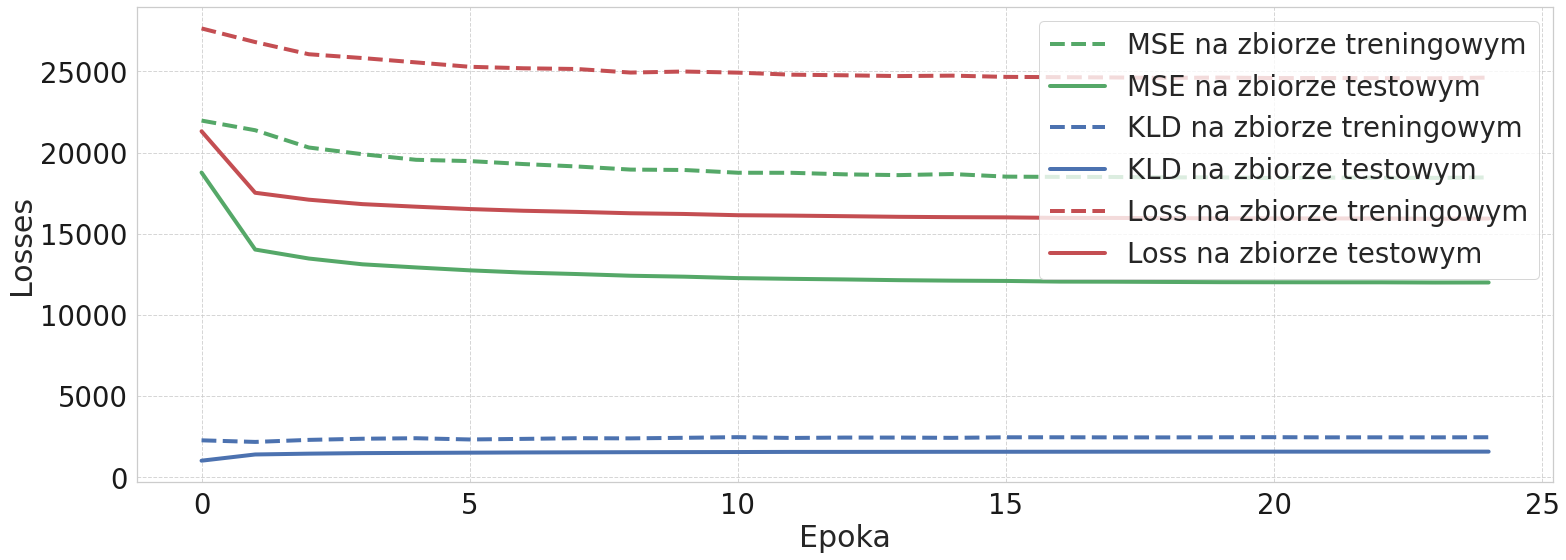

In [19]:
# loss
fig = plt.figure(figsize=(22, 8))
ax = fig.add_subplot(111)
ax.plot(
    scores["test"]["mse"],
    "g--",
    linewidth=4,
    markersize=12,
    label="MSE na zbiorze treningowym",
)
ax.plot(
    scores["train"]["mse"],
    "g-",
    linewidth=4,
    markersize=12,
    label="MSE na zbiorze testowym",
)
ax.plot(
    scores["test"]["kld"],
    "b--",
    linewidth=4,
    markersize=12,
    label="KLD na zbiorze treningowym",
)
ax.plot(
    scores["train"]["kld"],
    "b-",
    linewidth=4,
    markersize=12,
    label="KLD na zbiorze testowym",
)
ax.plot(
    scores["test"]["loss"],
    "r--",
    linewidth=4,
    markersize=12,
    label="Loss na zbiorze treningowym",
)
ax.plot(
    scores["train"]["loss"],
    "r-",
    linewidth=4,
    markersize=12,
    label="Loss na zbiorze testowym",
)
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.legend(loc=0)
ax.set_ylabel("Losses")
ax.set_xlabel("Epoka")
plt.tight_layout(pad=0.5)

plt.show()
plt.close()

Poniżej pokazujemy jak wyuczona sieć VAE rekonstruuje obrazki ze zbioru MNIST. W tym celu przepuszczamy przez sieć obrazki ze zbioru walidującego (górny wiersz obrazka), a sieć zwraca ich rekonstrukcje (dolny wiersz obrazka).  

  0%|          | 0/50 [00:00<?, ?it/s]

Ewaluation MSE: 0.01834


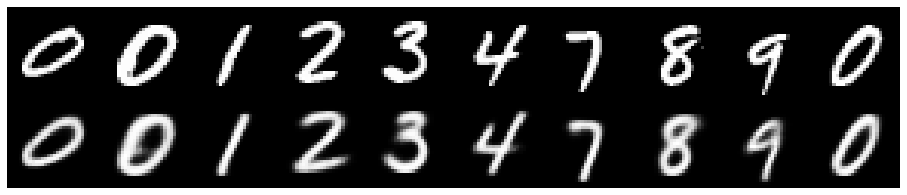

In [20]:
# validating
model.eval()

mses = AverageMeter()

with torch.no_grad():
    eval_tqdm = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
    for i, (image, _) in eval_tqdm:
        image = image.to(device)

        recon_batch, mu, log_var = model(image)
        mse = torch.nn.functional.mse_loss(recon_batch, image)
        mses.update(mse.item(), image.shape[0])

        eval_tqdm.set_description(f"mse: {mses.val:.4g} ({mses.avg:.4g})]")

        if i == len(test_loader) - 1:
            show(image, recon_batch, 10)

print(f"Ewaluation MSE: {mses.avg:.4g}")

Teraz przestawiamy przykładowe obrazki jakie zostały wygenerowanie poprzez wylosowanie z rozkładu $\mathcal{N}(0, 1)$ kilku wektorów z przestrzeni latent i przepuszczenie ich przez część dekodującą sieci VAE. 

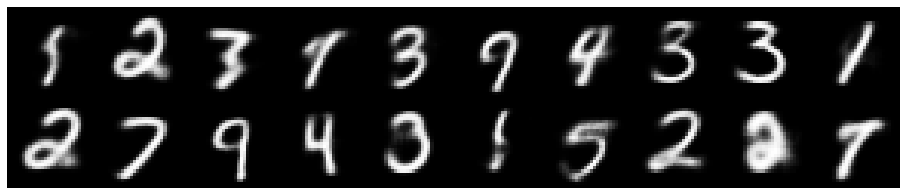

In [24]:
# generation
model.eval()

with torch.no_grad():
    imgs = model.sample(20, device)
    show(imgs, None, 10)

W celu policzenia *FID score* zapiszemy w jednym folderze obrazki pochodzące ze zbioru walidującego MNIST, zaś w drugim folderze losowo generujemy taką samą liczbę obrazków z wyuczonego modelu VAE.  

In [ ]:
from pathlib import Path
from PIL import Image


total_imgs = 10000


Path("orig_mnist_test").mkdir(parents=True, exist_ok=True)
if not any(Path("orig_mnist_test").iterdir()):
    n = 0
    eval_tqdm = tqdm(enumerate(test_loader), total=len(test_loader))
    for i, (image, _) in eval_tqdm:
        if n >= total_imgs:
            break
        image = image.to(device)

        for i in range(image.shape[0]):
            grid = torchvision.utils.make_grid(
                image[i], nrow=1, padding=0, normalize=True, scale_each=True
            )
            np_grid = grid.cpu().numpy()
            img = (np.transpose(np_grid, (1, 2, 0)) * 255).astype(np.uint8)
            im = Image.fromarray(img)
            im.save(f"orig_mnist_test/{n + i}.png")

        n += image.shape[0]


Path("vae_mnist").mkdir(parents=True, exist_ok=True)

if not any(Path("vae_mnist").iterdir()):
    model.eval()

    with torch.no_grad():
        for i in tqdm(range(total_imgs)):
            img = model.sample(1, device)

            grid = torchvision.utils.make_grid(
                img, nrow=1, padding=0, normalize=True, scale_each=True
            )
            np_grid = grid.cpu().numpy()
            img = (np.transpose(np_grid, (1, 2, 0)) * 255).astype(np.uint8)
            im = Image.fromarray(img)
            im.save(f"vae_mnist/{i}.png")

Teraz policzymy *FID score* podając ścieżki do obrazków oryginalnych i wygenerowanych przez wyuczoną sieć VAE.

In [28]:
import fid_score


device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
num_workers = 4
dims = 2048
paths = ["vae_mnist", "orig_mnist_test"]
batch_size = 100

fid_value = fid_score.calculate_fid_given_paths(
    paths, batch_size, device, dims, num_workers
)
print("FID: ", fid_value)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.32it/s]


FID:  33.46219060984103


# Wasserstein Autoencoder

Klasa ,,*WAE*'' definuje sieć wasserstein autoenkodera składająca się podobnie jak w poprzednich sieciach z dwóch części: kodującej (enkodera) i dekodującej (dekodera). Sieć bazuje na warstwach konwolucyjnych. Jest to kolejny model generatywny.

In [29]:
from typing import Tuple


class WAE(torch.nn.Module):
    def __init__(self, latent_dim: int, dim_hidden: int) -> None:
        super(WAE, self).__init__()

        self.latent_dim = latent_dim
        self.dim_h = dim_hidden

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, self.dim_h, 4, 2, 1, bias=False),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(self.dim_h * 2),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(self.dim_h * 4),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(self.dim_h * 8),
            torch.nn.ReLU(True),
            torch.nn.Flatten(),
            torch.nn.Linear(self.dim_h * (2**3), latent_dim),
        )

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, self.dim_h * 8 * 7 * 7),
            torch.nn.ReLU(True),
            View(-1, self.dim_h * 8, 7, 7),
            torch.nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            torch.nn.BatchNorm2d(self.dim_h * 4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            torch.nn.BatchNorm2d(self.dim_h * 2),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            torch.nn.Sigmoid(),
        )

    def forward(self, input_x: torch.Tensor) -> Tuple[torch.Tensor]:
        z = self.encoder(input_x)
        return z, self.decoder(z)

    def mmd_loss(self, x: torch.Tensor, y: torch.Tensor, sigma: float):
        norm_x = x.square().sum(1, keepdim=True)
        dist_x = norm_x + norm_x.t() - 2 * torch.mm(x, x.t())

        norm_y = y.square().sum(1, keepdim=True)
        dist_y = norm_y + norm_y.t() - 2 * torch.mm(y, y.t())

        dist = norm_x + norm_y.t() - 2 * torch.mm(x, y.t())

        res_1 = sigma / (sigma + dist_x) + sigma / (sigma + dist_y)
        res_1 = (1 - torch.eye(x.shape[0]).to(x.device)) * res_1
        res_1 = res_1.sum() / (x.shape[0] - 1)
        res_2 = sigma / (sigma + dist)
        res_2 = res_2.sum() * 2.0 / (x.shape[0])
        stats = res_1 - res_2
        return stats

    def sample(self, num_samples: int, device) -> torch.Tensor:
        z = torch.randn(num_samples, self.latent_dim, device=device)
        return self.decoder(z)

Uczenie modelu i jego walidacja.

In [ ]:
latent_dim = 8
dim_hidden = 16

model = WAE(latent_dim=latent_dim, dim_hidden=dim_hidden)
model = model.to(device)
print(model)
print(f"Number of parameters: {count_parameters(model)}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

use_scheduler = True
scheduler = None
if use_scheduler:
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.8**epoch, min_val=1e-5)


scale = 0.1
sigma = 2 * latent_dim * scale
C = 2.5

mse_loss = torch.nn.MSELoss()


print(f"{C=}, {sigma=}")

scores = {
    "train": {"loss": [], "mse": [], "mmd": []},
    "test": {"loss": [], "mse": [], "mmd": []},
}


epochs = 25
for epoch in range(epochs):

    # training
    model.train()

    losses = AverageMeter()
    mses = AverageMeter()
    mmds = AverageMeter()

    train_tqdm = tqdm(train_loader, total=len(train_loader), leave=False)
    for image, _ in train_tqdm:
        image = image.to(device)

        z_real, recon = model(image)
        z_fake = torch.randn(image.shape[0], latent_dim, device=device)

        mmd = model.mmd_loss(z_real, z_fake, sigma)
        mmd = mmd / image.shape[0]

        mse = mse_loss(recon, image)
        loss = mse + C * mmd

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.update(loss.item(), image.shape[0])
        mses.update(mse.item(), image.shape[0])
        mmds.update(mmd.item(), image.shape[0])

        train_tqdm.set_description(
            f"TRAIN [loss, mse]: "
            f"[{losses.val:.4g} ({losses.avg:.4g}),{mses.val:.4g} ({mses.avg:.4g})]"
        )

    scores["train"]["loss"].append(losses.avg)
    scores["train"]["mse"].append(mses.avg)
    scores["train"]["mmd"].append(mmds.avg)

    if use_scheduler:
        scheduler.step()

    # validating
    model.eval()

    losses = AverageMeter()
    mses = AverageMeter()
    mmds = AverageMeter()

    with torch.no_grad():
        eval_tqdm = tqdm(test_loader, total=len(test_loader), leave=False)
        for image, _ in eval_tqdm:
            image = image.to(device)

            z_real, recon = model(image)
            z_fake = torch.randn(image.shape[0], latent_dim, device=device)

            mmd = model.mmd_loss(z_real, z_fake, sigma)
            mmd = mmd / image.shape[0]

            mse = mse_loss(recon, image)
            loss = mse + C * mmd

            losses.update(loss.item(), image.shape[0])
            mses.update(mse.item(), image.shape[0])
            klds.update(mmd.item(), image.shape[0])

            eval_tqdm.set_description(
                f"TEST [loss, mse]: "
                f"[{losses.val:.4g} ({losses.avg:.4g}),{mses.val:.4g} ({mses.avg:.4g})]"
            )

    scores["test"]["loss"].append(losses.avg)
    scores["test"]["mse"].append(mses.avg)
    scores["test"]["mmd"].append(mmds.avg)

    print(
        f"Epoch: [{epoch + 1}/{epochs}]; "
        f"train: ({scores['train']['loss'][-1]:.4g},{scores['train']['mse'][-1]:.4g},"
        f"{scores['train']['mmd'][-1]:.4g}); "
        f"test: ({scores['test']['loss'][-1]:.4f},{scores['test']['mse'][-1]:.4g},"
        f"{scores['test']['mmd'][-1]:.4g})"
        f"{f'; lr: {scheduler.get_last_lr()[0]:.4g}' if use_scheduler else ''}"
    )

torch.save(
    model.state_dict(), "wae.pth"
)  # zapisujemy model do dalszej ewaluacji np. obliczenia FID score

Poniżej pokazujemy jak przebiega proces uczenia modelu WAE.

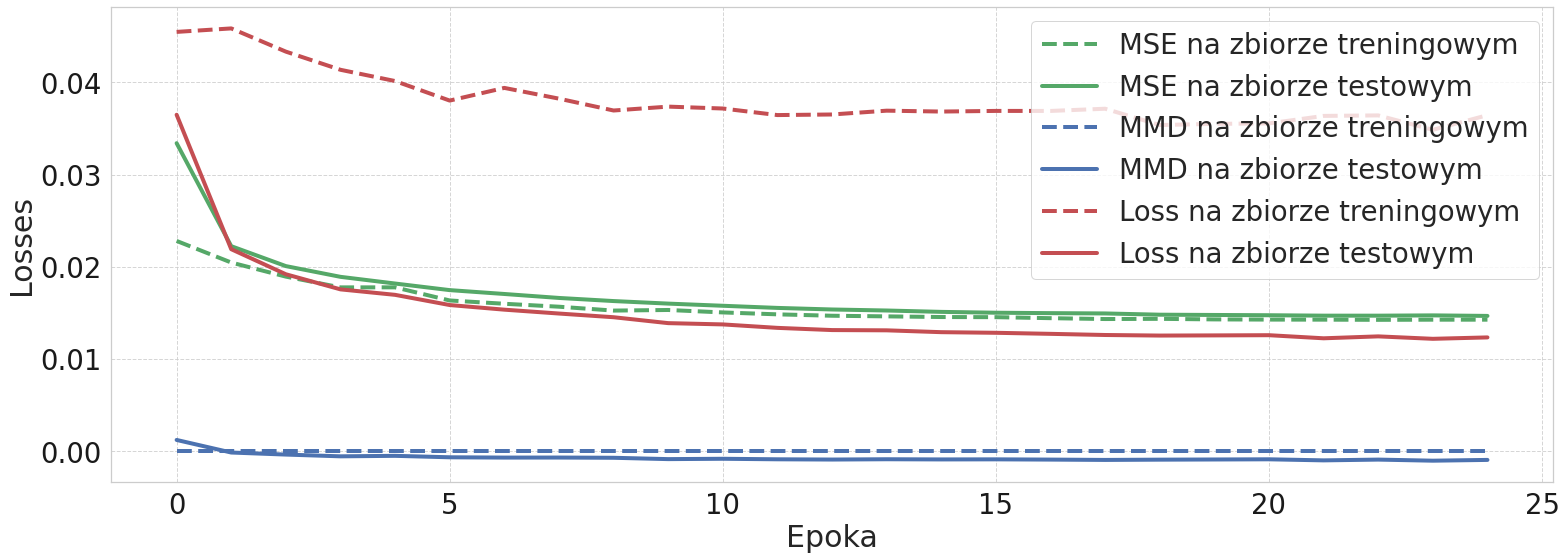

In [32]:
# loss
fig = plt.figure(figsize=(22, 8))
ax = fig.add_subplot(111)
ax.plot(
    scores["test"]["mse"],
    "g--",
    linewidth=4,
    markersize=12,
    label="MSE na zbiorze treningowym",
)
ax.plot(
    scores["train"]["mse"],
    "g-",
    linewidth=4,
    markersize=12,
    label="MSE na zbiorze testowym",
)
ax.plot(
    scores["test"]["mmd"],
    "b--",
    linewidth=4,
    markersize=12,
    label="MMD na zbiorze treningowym",
)
ax.plot(
    scores["train"]["mmd"],
    "b-",
    linewidth=4,
    markersize=12,
    label="MMD na zbiorze testowym",
)
ax.plot(
    scores["test"]["loss"],
    "r--",
    linewidth=4,
    markersize=12,
    label="Loss na zbiorze treningowym",
)
ax.plot(
    scores["train"]["loss"],
    "r-",
    linewidth=4,
    markersize=12,
    label="Loss na zbiorze testowym",
)
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.legend(loc=0)
ax.set_ylabel("Losses")
ax.set_xlabel("Epoka")
plt.tight_layout(pad=0.5)

plt.show()
plt.close()

Poniżej pokazujemy jak wyuczona sieć WAE rekonstruuje obrazki ze zbioru MNIST. W tym celu przepuszczamy przez sieć obrazki ze zbioru walidującego (górny wiersz obrazka), a sieć zwraca ich rekonstrukcje (dolny wiersz obrazka). 

  0%|          | 0/50 [00:00<?, ?it/s]

Ewaluation MSE: 0.01427


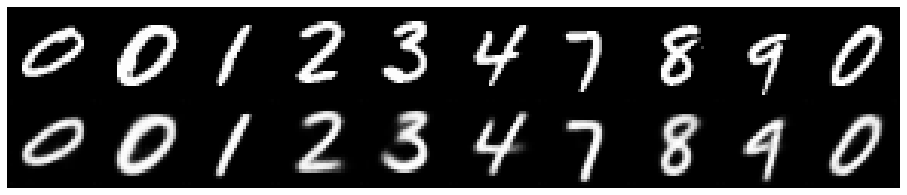

In [33]:
# validating
model.eval()

mses = AverageMeter()

with torch.no_grad():
    eval_tqdm = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
    for i, (image, _) in eval_tqdm:
        image = image.to(device)

        latent, recon = model(image)
        mse = torch.nn.functional.mse_loss(recon, image)
        mses.update(mse.item(), image.shape[0])

        eval_tqdm.set_description(f"mse: {mses.val:.4g} ({mses.avg:.4g})]")

        if i == len(test_loader) - 1:
            show(image, recon, 10)

print(f"Ewaluation MSE: {mses.avg:.4g}")

Teraz przestawiamy przykładowe obrazki jakie zostały wygenerowanie poprzez wylosowanie z rozkładu $\mathcal{N}(0,1)$ kilku wektorów z przestrzeni latent i przepuszczenie ich przez część dekodującą sieci WAE. 

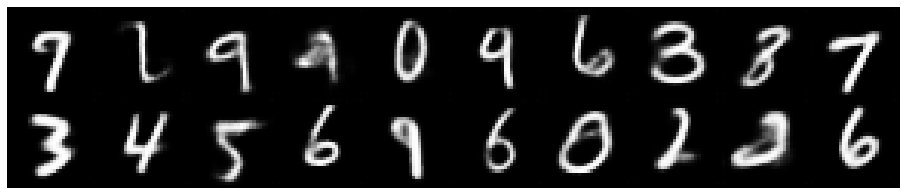

In [36]:
# generation
model.eval()

with torch.no_grad():
    imgs = model.sample(20, device)
    show(imgs, None, 10)

W celu policzenia *FID score* zapiszemy w jednym folderze obrazki pochodzące ze zbioru walidującego MNIST, zaś w drugim folderze losowo generujemy taką samą liczbę obrazków z wyuczonego modelu WAE.  

In [ ]:
from PIL import Image


total_imgs = 10000


Path("orig_mnist_test").mkdir(parents=True, exist_ok=True)
if not any(Path("orig_mnist_test").iterdir()):
    n = 0
    eval_tqdm = tqdm(enumerate(test_loader), total=len(test_loader))
    for i, (image, _) in eval_tqdm:
        if n >= total_imgs:
            break
        image = image.to(device)

        for i in range(image.shape[0]):
            grid = torchvision.utils.make_grid(
                image[i], nrow=1, padding=0, normalize=True, scale_each=True
            )
            np_grid = grid.cpu().numpy()
            img = (np.transpose(np_grid, (1, 2, 0)) * 255).astype(np.uint8)
            im = Image.fromarray(img)
            im.save(f"orig_mnist_test/{n + i}.png")

        n += image.shape[0]


Path("wae_mnist").mkdir(parents=True, exist_ok=True)

if not any(Path("wae_mnist").iterdir()):
    model.eval()

    with torch.no_grad():
        for i in tqdm(range(total_imgs)):
            img = model.sample(1, device)

            grid = torchvision.utils.make_grid(
                img, nrow=1, padding=0, normalize=True, scale_each=True
            )
            np_grid = grid.cpu().numpy()
            img = (np.transpose(np_grid, (1, 2, 0)) * 255).astype(np.uint8)
            im = Image.fromarray(img)
            im.save(f"wae_mnist/{i}.png")

Teraz policzymy *FID score* podając ścieżki do obrazków oryginalnych i wygenerowanych przez wyuczoną sieć WAE.

In [38]:
import fid_score


device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
num_workers = 4
dims = 2048
paths = ["wae_mnist", "orig_mnist_test"]
batch_size = 100

fid_value = fid_score.calculate_fid_given_paths(
    paths, batch_size, device, dims, num_workers
)
print("FID: ", fid_value)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.14it/s]


FID:  26.162936463324684
